In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [68]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)

CUDA is available. Using GPU.
Tensor is on device: cuda:0


## Example Pinball loss / Quantile loss

In [69]:
tau=0.1
y_hat=3
y=np.linspace(y_hat-10,y_hat+10,100)

# Calculate loss
loss=(1-tau)*(np.abs(y-y_hat))
y_larger=y>y_hat
loss[y_larger]=tau*(np.abs(y[y_larger]-y_hat))

In [70]:
loss=(1-tau)*(np.abs(y-y_hat))
y_larger=y>y_hat

loss[y_larger]=tau*(np.abs(y[y_larger]-y_hat))

In [71]:
tau=0.1
y_hat=3
u=np.linspace(-100,100,1000)
u_ints=np.unique(np.ceil(u))
u_ticks=u_ints[np.nonzero((u_ints%2)==0)]

def plot_function(tau):
    
    loss=(1-tau)*(np.abs(u))
    y_larger=u<0
    loss[y_larger]=tau*(np.abs(u[y_larger]))

    plt.plot(u,loss)
    plt.rcParams["figure.figsize"] = [10, 5]
    plt.grid()
    plt.xticks(u_ticks)
    plt.xlim([-10,10])
    plt.ylim([-1,8])
    plt.legend([r'$\mathcal{L}(y_{\tau},y)$',r'$y_{\tau}$'])
    plt.xlabel(r"$u=y_{\tau}-y$")
    plt.ylabel(r'$\mathcal{L}$')
    plt.title(r'Example of the Quantile loss / Pinball loss function')
    plt.show()
    
interact(plot_function, tau = widgets.FloatSlider(value=0.1,
                                               min=0.0,
                                               max=1.0,
                                               step=0.01))

interactive(children=(FloatSlider(value=0.1, description='tau', max=1.0, step=0.01), Output()), _dom_classes=(…

<function __main__.plot_function(tau)>

## Plot for report

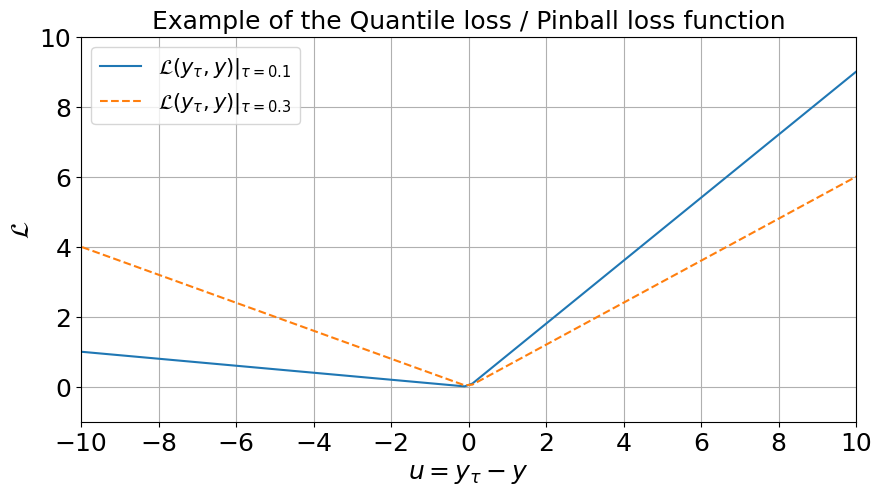

In [72]:
tau=0.1
u=np.linspace(-100,100,1000)
u_ints=np.unique(np.ceil(u))
u_ticks=u_ints[np.nonzero((u_ints%2)==0)]    

loss=(1-tau)*(np.abs(u))
y_larger=u<0
loss[y_larger]=tau*(np.abs(u[y_larger]))

tau_2=0.4
loss_2=(1-tau_2)*(np.abs(u))
loss_2[y_larger]=tau_2*(np.abs(u[y_larger]))

fontsize=18

plt.plot(u,loss)
plt.plot(u,loss_2,'--')
plt.rcParams["figure.figsize"] = [10, 5]
plt.grid()
plt.xticks(u_ticks,fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlim([-10,10])
plt.ylim([-1,10])
plt.legend([r'$\mathcal{L}(y_{\tau},y)|_{\tau =0.1}$',r'$\mathcal{L}(y_{\tau},y)|_{\tau =0.3}$'],fontsize=fontsize-3)
plt.xlabel(r"$u=y_{\tau}-y$",fontsize=fontsize)
plt.ylabel(r'$\mathcal{L}$',fontsize=fontsize)
plt.title(r'Example of the Quantile loss / Pinball loss function',fontsize=fontsize)
plt.show()

## Example Quantile Regression Neural Networks (QRNN)

In [73]:
def draw_sample_sin(n_samps, sigma):
    x=np.random.uniform(low=0,high=2*np.pi,size=n_samps)
    noise=np.random.normal(loc=0,scale=sigma,size=n_samps)
    y=np.sin(x)+noise
    return x,y

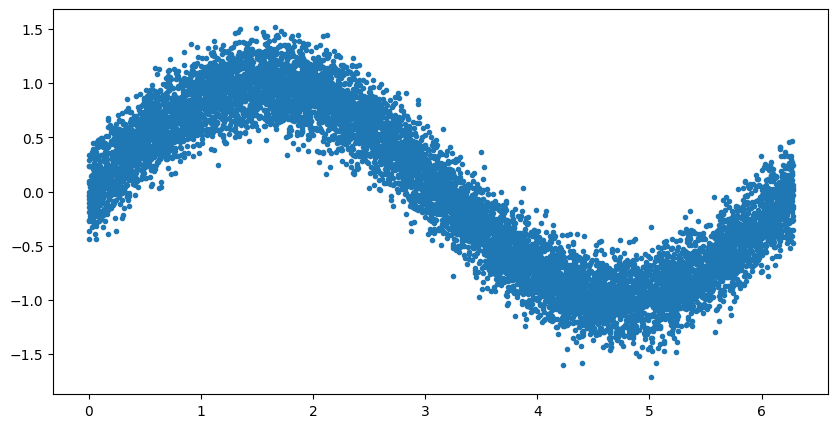

In [74]:
x,y = draw_sample_sin(10000,0.2)
plt.plot(x,y,'.')

In [75]:
x=np.array([x]).T
X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=0.05)


import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train)), int(len(X_train)*val_size)))
train_indices=[i for i in range(len(X_train)) if np.any(validation_indices==i)==False]

quantiles=np.array([0.1,0.5,0.9])
batch_size=500


In [76]:
nepochs=200
quantiles=[0.1,0.5,0.9]
model=QuantileNetwork(quantiles=quantiles)

# Add everything but the output layer
sequence=nn.Sequential(
    nn.Linear(1,64),
    nn.ReLU(),
    nn.Linear(64, len(quantiles)*1) #Output dimesion is number of quantiles times number of target variables
)
model.fit(X_train,y_train, 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence)

Epoch 1


Batch number: 100%|██████████| 19/19 [00:00<00:00, 452.99it/s]

Training loss [0.43402293] Validation loss [0.37990192]
----New best validation loss---- [0.37990192]
Epoch 2



Batch number: 100%|██████████| 19/19 [00:00<00:00, 488.79it/s]

Training loss [0.3632738] Validation loss [0.3555529]
----New best validation loss---- [0.3555529]
Epoch 3



Batch number: 100%|██████████| 19/19 [00:00<00:00, 489.15it/s]

Training loss [0.34674552] Validation loss [0.34439194]
----New best validation loss---- [0.34439194]
Epoch 4



Batch number: 100%|██████████| 19/19 [00:00<00:00, 516.29it/s]

Training loss [0.33568063] Validation loss [0.3341202]
----New best validation loss---- [0.3341202]
Epoch 5



Batch number: 100%|██████████| 19/19 [00:00<00:00, 516.22it/s]

Training loss [0.3243295] Validation loss [0.3250671]
----New best validation loss---- [0.3250671]
Epoch 6



Batch number: 100%|██████████| 19/19 [00:00<00:00, 510.21it/s]

Training loss [0.3135527] Validation loss [0.31550002]
----New best validation loss---- [0.31550002]
Epoch 7



Batch number: 100%|██████████| 19/19 [00:00<00:00, 518.06it/s]

Training loss [0.30323377] Validation loss [0.3061314]
----New best validation loss---- [0.3061314]
Epoch 8



Batch number: 100%|██████████| 19/19 [00:00<00:00, 529.03it/s]

Training loss [0.2926902] Validation loss [0.2955621]
----New best validation loss---- [0.2955621]
Epoch 9



Batch number: 100%|██████████| 19/19 [00:00<00:00, 503.35it/s]

Training loss [0.28245762] Validation loss [0.2877859]
----New best validation loss---- [0.2877859]
Epoch 10



Batch number: 100%|██████████| 19/19 [00:00<00:00, 531.64it/s]

Training loss [0.27433622] Validation loss [0.28116453]
----New best validation loss---- [0.28116453]
Epoch 11



Batch number: 100%|██████████| 19/19 [00:00<00:00, 503.36it/s]

Training loss [0.26796934] Validation loss [0.2760185]
----New best validation loss---- [0.2760185]
Epoch 12



Batch number: 100%|██████████| 19/19 [00:00<00:00, 461.02it/s]

Training loss [0.2626314] Validation loss [0.27074233]
----New best validation loss---- [0.27074233]
Epoch 13



Batch number: 100%|██████████| 19/19 [00:00<00:00, 469.60it/s]

Training loss [0.25733227] Validation loss [0.26653624]
----New best validation loss---- [0.26653624]
Epoch 14



Batch number: 100%|██████████| 19/19 [00:00<00:00, 462.62it/s]

Training loss [0.25303712] Validation loss [0.26241425]
----New best validation loss---- [0.26241425]
Epoch 15



Batch number: 100%|██████████| 19/19 [00:00<00:00, 454.17it/s]

Training loss [0.24914834] Validation loss [0.25803152]
----New best validation loss---- [0.25803152]
Epoch 16



Batch number: 100%|██████████| 19/19 [00:00<00:00, 492.23it/s]

Training loss [0.24509197] Validation loss [0.25436342]
----New best validation loss---- [0.25436342]
Epoch 17



Batch number: 100%|██████████| 19/19 [00:00<00:00, 454.97it/s]

Training loss [0.24161296] Validation loss [0.25181237]
----New best validation loss---- [0.25181237]
Epoch 18



Batch number: 100%|██████████| 19/19 [00:00<00:00, 491.39it/s]

Training loss [0.23825055] Validation loss [0.24835424]
----New best validation loss---- [0.24835424]
Epoch 19



Batch number: 100%|██████████| 19/19 [00:00<00:00, 438.36it/s]

Training loss [0.23476495] Validation loss [0.24470519]
----New best validation loss---- [0.24470519]
Epoch 20



Batch number: 100%|██████████| 19/19 [00:00<00:00, 445.03it/s]

Training loss [0.23165299] Validation loss [0.24064891]
----New best validation loss---- [0.24064891]
Epoch 21



Batch number: 100%|██████████| 19/19 [00:00<00:00, 510.14it/s]

Training loss [0.22859143] Validation loss [0.23834613]
----New best validation loss---- [0.23834613]
Epoch 22



Batch number: 100%|██████████| 19/19 [00:00<00:00, 508.48it/s]

Training loss [0.22521202] Validation loss [0.23475835]
----New best validation loss---- [0.23475835]
Epoch 23



Batch number: 100%|██████████| 19/19 [00:00<00:00, 566.50it/s]

Training loss [0.22214402] Validation loss [0.23192634]
----New best validation loss---- [0.23192634]
Epoch 24



Batch number: 100%|██████████| 19/19 [00:00<00:00, 460.24it/s]

Training loss [0.22001085] Validation loss [0.22880858]
----New best validation loss---- [0.22880858]
Epoch 25



Batch number: 100%|██████████| 19/19 [00:00<00:00, 490.11it/s]

Training loss [0.21665472] Validation loss [0.22508357]
----New best validation loss---- [0.22508357]
Epoch 26



Batch number: 100%|██████████| 19/19 [00:00<00:00, 482.26it/s]

Training loss [0.21350652] Validation loss [0.22201736]
----New best validation loss---- [0.22201736]
Epoch 27



Batch number: 100%|██████████| 19/19 [00:00<00:00, 490.93it/s]

Training loss [0.21048285] Validation loss [0.21979056]
----New best validation loss---- [0.21979056]
Epoch 28



Batch number: 100%|██████████| 19/19 [00:00<00:00, 487.36it/s]

Training loss [0.20785594] Validation loss [0.21578526]
----New best validation loss---- [0.21578526]
Epoch 29



Batch number: 100%|██████████| 19/19 [00:00<00:00, 499.48it/s]

Training loss [0.20508493] Validation loss [0.2129543]
----New best validation loss---- [0.2129543]
Epoch 30



Batch number: 100%|██████████| 19/19 [00:00<00:00, 540.31it/s]

Training loss [0.20242015] Validation loss [0.21057042]
----New best validation loss---- [0.21057042]
Epoch 31



Batch number: 100%|██████████| 19/19 [00:00<00:00, 514.12it/s]

Training loss [0.20001896] Validation loss [0.20750013]
----New best validation loss---- [0.20750013]
Epoch 32



Batch number: 100%|██████████| 19/19 [00:00<00:00, 503.84it/s]

Training loss [0.19751264] Validation loss [0.20476356]
----New best validation loss---- [0.20476356]
Epoch 33



Batch number: 100%|██████████| 19/19 [00:00<00:00, 499.17it/s]

Training loss [0.19520015] Validation loss [0.20236266]
----New best validation loss---- [0.20236266]
Epoch 34



Batch number: 100%|██████████| 19/19 [00:00<00:00, 510.85it/s]

Training loss [0.19274001] Validation loss [0.19936419]
----New best validation loss---- [0.19936419]
Epoch 35



Batch number: 100%|██████████| 19/19 [00:00<00:00, 532.78it/s]

Training loss [0.19074696] Validation loss [0.19701535]
----New best validation loss---- [0.19701535]
Epoch 36



Batch number: 100%|██████████| 19/19 [00:00<00:00, 523.64it/s]

Training loss [0.18833297] Validation loss [0.19448099]
----New best validation loss---- [0.19448099]
Epoch 37



Batch number: 100%|██████████| 19/19 [00:00<00:00, 507.55it/s]

Training loss [0.18623394] Validation loss [0.19280909]
----New best validation loss---- [0.19280909]
Epoch 38



Batch number: 100%|██████████| 19/19 [00:00<00:00, 500.49it/s]

Training loss [0.18441021] Validation loss [0.19059479]
----New best validation loss---- [0.19059479]
Epoch 39



Batch number: 100%|██████████| 19/19 [00:00<00:00, 526.70it/s]

Training loss [0.18274078] Validation loss [0.1880948]
----New best validation loss---- [0.1880948]
Epoch 40



Batch number: 100%|██████████| 19/19 [00:00<00:00, 529.74it/s]

Training loss [0.18087995] Validation loss [0.18617266]
----New best validation loss---- [0.18617266]
Epoch 41



Batch number: 100%|██████████| 19/19 [00:00<00:00, 525.43it/s]

Training loss [0.1793556] Validation loss [0.18504156]
----New best validation loss---- [0.18504156]
Epoch 42



Batch number: 100%|██████████| 19/19 [00:00<00:00, 530.70it/s]

Training loss [0.1776496] Validation loss [0.18362246]
----New best validation loss---- [0.18362246]
Epoch 43



Batch number: 100%|██████████| 19/19 [00:00<00:00, 528.65it/s]

Training loss [0.17639506] Validation loss [0.18345876]
----New best validation loss---- [0.18345876]
Epoch 44



Batch number: 100%|██████████| 19/19 [00:00<00:00, 519.26it/s]

Training loss [0.17516959] Validation loss [0.17968798]
----New best validation loss---- [0.17968798]
Epoch 45



Batch number: 100%|██████████| 19/19 [00:00<00:00, 490.46it/s]

Training loss [0.17338747] Validation loss [0.18318647]
Epoch 46



Batch number: 100%|██████████| 19/19 [00:00<00:00, 459.87it/s]

Training loss [0.17253606] Validation loss [0.177181]
----New best validation loss---- [0.177181]
Epoch 47



Batch number: 100%|██████████| 19/19 [00:00<00:00, 458.24it/s]

Training loss [0.17073908] Validation loss [0.17672192]
----New best validation loss---- [0.17672192]
Epoch 48



Batch number: 100%|██████████| 19/19 [00:00<00:00, 454.91it/s]

Training loss [0.17004283] Validation loss [0.17644991]
----New best validation loss---- [0.17644991]
Epoch 49



Batch number: 100%|██████████| 19/19 [00:00<00:00, 461.26it/s]

Training loss [0.16939516] Validation loss [0.17715251]
Epoch 50



Batch number: 100%|██████████| 19/19 [00:00<00:00, 459.68it/s]

Training loss [0.16842023] Validation loss [0.17363194]
----New best validation loss---- [0.17363194]
Epoch 51



Batch number: 100%|██████████| 19/19 [00:00<00:00, 447.76it/s]

Training loss [0.16725485] Validation loss [0.17282753]
----New best validation loss---- [0.17282753]
Epoch 52



Batch number: 100%|██████████| 19/19 [00:00<00:00, 457.39it/s]

Training loss [0.16602296] Validation loss [0.17164081]
----New best validation loss---- [0.17164081]
Epoch 53



Batch number: 100%|██████████| 19/19 [00:00<00:00, 476.63it/s]

Training loss [0.1654218] Validation loss [0.17097954]
----New best validation loss---- [0.17097954]
Epoch 54



Batch number: 100%|██████████| 19/19 [00:00<00:00, 456.61it/s]

Training loss [0.16446735] Validation loss [0.16992766]
----New best validation loss---- [0.16992766]
Epoch 55



Batch number: 100%|██████████| 19/19 [00:00<00:00, 473.28it/s]

Training loss [0.16378342] Validation loss [0.1713202]
Epoch 56



Batch number: 100%|██████████| 19/19 [00:00<00:00, 458.33it/s]

Training loss [0.16421288] Validation loss [0.17290953]
Epoch 57



Batch number: 100%|██████████| 19/19 [00:00<00:00, 466.42it/s]

Training loss [0.16418992] Validation loss [0.17326678]
Epoch 58



Batch number: 100%|██████████| 19/19 [00:00<00:00, 446.91it/s]

Training loss [0.1634331] Validation loss [0.16700757]
----New best validation loss---- [0.16700757]
Epoch 59



Batch number: 100%|██████████| 19/19 [00:00<00:00, 474.97it/s]

Training loss [0.16150433] Validation loss [0.16716133]
Epoch 60



Batch number: 100%|██████████| 19/19 [00:00<00:00, 445.92it/s]

Training loss [0.16130501] Validation loss [0.16781706]
Epoch 61



Batch number: 100%|██████████| 19/19 [00:00<00:00, 457.73it/s]

Training loss [0.16108702] Validation loss [0.16530809]
----New best validation loss---- [0.16530809]
Epoch 62



Batch number: 100%|██████████| 19/19 [00:00<00:00, 449.47it/s]

Training loss [0.16068538] Validation loss [0.16497536]
----New best validation loss---- [0.16497536]
Epoch 63



Batch number: 100%|██████████| 19/19 [00:00<00:00, 453.02it/s]

Training loss [0.1601967] Validation loss [0.16662472]
Epoch 64



Batch number: 100%|██████████| 19/19 [00:00<00:00, 454.23it/s]

Training loss [0.15946172] Validation loss [0.16373555]
----New best validation loss---- [0.16373555]
Epoch 65



Batch number: 100%|██████████| 19/19 [00:00<00:00, 464.72it/s]

Training loss [0.15878297] Validation loss [0.16377527]
Epoch 66



Batch number: 100%|██████████| 19/19 [00:00<00:00, 455.15it/s]

Training loss [0.1587267] Validation loss [0.1634259]
----New best validation loss---- [0.1634259]
Epoch 67



Batch number: 100%|██████████| 19/19 [00:00<00:00, 453.86it/s]

Training loss [0.15873736] Validation loss [0.16383374]
Epoch 68



Batch number: 100%|██████████| 19/19 [00:00<00:00, 448.64it/s]

Training loss [0.15875772] Validation loss [0.16405806]
Epoch 69



Batch number: 100%|██████████| 19/19 [00:00<00:00, 482.96it/s]

Training loss [0.15827423] Validation loss [0.16326633]
----New best validation loss---- [0.16326633]
Epoch 70



Batch number: 100%|██████████| 19/19 [00:00<00:00, 470.15it/s]

Training loss [0.15781154] Validation loss [0.16229354]
----New best validation loss---- [0.16229354]
Epoch 71



Batch number: 100%|██████████| 19/19 [00:00<00:00, 483.74it/s]

Training loss [0.15741159] Validation loss [0.16201289]
----New best validation loss---- [0.16201289]
Epoch 72



Batch number: 100%|██████████| 19/19 [00:00<00:00, 518.44it/s]

Training loss [0.15694617] Validation loss [0.16109902]
----New best validation loss---- [0.16109902]
Epoch 73



Batch number: 100%|██████████| 19/19 [00:00<00:00, 534.52it/s]

Training loss [0.15706196] Validation loss [0.16235588]
Epoch 74



Batch number: 100%|██████████| 19/19 [00:00<00:00, 512.77it/s]

Training loss [0.15708844] Validation loss [0.16105953]
----New best validation loss---- [0.16105953]
Epoch 75



Batch number: 100%|██████████| 19/19 [00:00<00:00, 522.80it/s]

Training loss [0.15657423] Validation loss [0.16106571]
Epoch 76



Batch number: 100%|██████████| 19/19 [00:00<00:00, 515.27it/s]

Training loss [0.15625577] Validation loss [0.16078441]
----New best validation loss---- [0.16078441]
Epoch 77



Batch number: 100%|██████████| 19/19 [00:00<00:00, 504.19it/s]

Training loss [0.15632516] Validation loss [0.16044985]
----New best validation loss---- [0.16044985]
Epoch 78



Batch number: 100%|██████████| 19/19 [00:00<00:00, 523.77it/s]

Training loss [0.15613] Validation loss [0.16017032]
----New best validation loss---- [0.16017032]
Epoch 79



Batch number: 100%|██████████| 19/19 [00:00<00:00, 513.06it/s]

Training loss [0.1561102] Validation loss [0.1607277]
Epoch 80



Batch number: 100%|██████████| 19/19 [00:00<00:00, 496.70it/s]

Training loss [0.15571877] Validation loss [0.16005681]
----New best validation loss---- [0.16005681]
Epoch 81



Batch number: 100%|██████████| 19/19 [00:00<00:00, 523.86it/s]

Training loss [0.15570866] Validation loss [0.15980394]
----New best validation loss---- [0.15980394]
Epoch 82



Batch number: 100%|██████████| 19/19 [00:00<00:00, 520.97it/s]

Training loss [0.15608814] Validation loss [0.16091628]
Epoch 83



Batch number: 100%|██████████| 19/19 [00:00<00:00, 507.98it/s]

Training loss [0.15546668] Validation loss [0.16023502]
Epoch 84



Batch number: 100%|██████████| 19/19 [00:00<00:00, 493.30it/s]

Training loss [0.15522663] Validation loss [0.15977056]
----New best validation loss---- [0.15977056]
Epoch 85



Batch number: 100%|██████████| 19/19 [00:00<00:00, 538.39it/s]

Training loss [0.15506822] Validation loss [0.15924579]
----New best validation loss---- [0.15924579]
Epoch 86



Batch number: 100%|██████████| 19/19 [00:00<00:00, 503.48it/s]

Training loss [0.15490279] Validation loss [0.15988724]
Epoch 87



Batch number: 100%|██████████| 19/19 [00:00<00:00, 511.45it/s]

Training loss [0.15499566] Validation loss [0.15950458]
Epoch 88



Batch number: 100%|██████████| 19/19 [00:00<00:00, 512.53it/s]

Training loss [0.1554204] Validation loss [0.15968448]
Epoch 89



Batch number: 100%|██████████| 19/19 [00:00<00:00, 531.14it/s]

Training loss [0.1548367] Validation loss [0.15912989]
----New best validation loss---- [0.15912989]
Epoch 90



Batch number: 100%|██████████| 19/19 [00:00<00:00, 500.00it/s]

Training loss [0.15466602] Validation loss [0.15913889]
Epoch 91



Batch number: 100%|██████████| 19/19 [00:00<00:00, 513.39it/s]

Training loss [0.15441446] Validation loss [0.15972069]
Epoch 92



Batch number: 100%|██████████| 19/19 [00:00<00:00, 478.86it/s]

Training loss [0.15437506] Validation loss [0.15846322]
----New best validation loss---- [0.15846322]
Epoch 93



Batch number: 100%|██████████| 19/19 [00:00<00:00, 461.41it/s]

Training loss [0.15435141] Validation loss [0.15892391]
Epoch 94



Batch number: 100%|██████████| 19/19 [00:00<00:00, 512.86it/s]

Training loss [0.15476471] Validation loss [0.16118303]
Epoch 95



Batch number: 100%|██████████| 19/19 [00:00<00:00, 524.77it/s]

Training loss [0.15468554] Validation loss [0.1584442]
----New best validation loss---- [0.1584442]
Epoch 96



Batch number: 100%|██████████| 19/19 [00:00<00:00, 520.32it/s]

Training loss [0.15432304] Validation loss [0.15845545]
Epoch 97



Batch number: 100%|██████████| 19/19 [00:00<00:00, 525.95it/s]

Training loss [0.15439504] Validation loss [0.15944085]
Epoch 98



Batch number: 100%|██████████| 19/19 [00:00<00:00, 512.22it/s]

Training loss [0.1542051] Validation loss [0.15830036]
----New best validation loss---- [0.15830036]
Epoch 99



Batch number: 100%|██████████| 19/19 [00:00<00:00, 524.06it/s]

Training loss [0.15396707] Validation loss [0.15882696]
Epoch 100



Batch number: 100%|██████████| 19/19 [00:00<00:00, 516.71it/s]

Training loss [0.15383086] Validation loss [0.15840119]
Epoch 101



Batch number: 100%|██████████| 19/19 [00:00<00:00, 515.03it/s]

Training loss [0.1538844] Validation loss [0.15794437]
----New best validation loss---- [0.15794437]
Epoch 102



Batch number: 100%|██████████| 19/19 [00:00<00:00, 533.35it/s]

Training loss [0.1538184] Validation loss [0.16082525]
Epoch 103



Batch number: 100%|██████████| 19/19 [00:00<00:00, 513.43it/s]

Training loss [0.15416077] Validation loss [0.15872106]
Epoch 104



Batch number: 100%|██████████| 19/19 [00:00<00:00, 513.67it/s]

Training loss [0.15371767] Validation loss [0.16030103]
Epoch 105



Batch number: 100%|██████████| 19/19 [00:00<00:00, 523.57it/s]

Training loss [0.15463047] Validation loss [0.16019389]
Epoch 106



Batch number: 100%|██████████| 19/19 [00:00<00:00, 514.48it/s]

Training loss [0.1537631] Validation loss [0.158532]
Epoch 107



Batch number: 100%|██████████| 19/19 [00:00<00:00, 522.16it/s]

Training loss [0.15356563] Validation loss [0.16012247]
Epoch 108



Batch number: 100%|██████████| 19/19 [00:00<00:00, 507.86it/s]

Training loss [0.15382665] Validation loss [0.15808141]
Epoch 109



Batch number: 100%|██████████| 19/19 [00:00<00:00, 508.80it/s]

Training loss [0.15334344] Validation loss [0.15833396]
Epoch 110



Batch number: 100%|██████████| 19/19 [00:00<00:00, 524.78it/s]

Training loss [0.15354742] Validation loss [0.15790188]
----New best validation loss---- [0.15790188]
Epoch 111



Batch number: 100%|██████████| 19/19 [00:00<00:00, 528.35it/s]

Training loss [0.15339223] Validation loss [0.15888661]
Epoch 112



Batch number: 100%|██████████| 19/19 [00:00<00:00, 527.81it/s]

Training loss [0.15380457] Validation loss [0.15902336]
Epoch 113



Batch number: 100%|██████████| 19/19 [00:00<00:00, 533.78it/s]

Training loss [0.15334111] Validation loss [0.15897849]
Epoch 114



Batch number: 100%|██████████| 19/19 [00:00<00:00, 506.55it/s]

Training loss [0.15400048] Validation loss [0.1603545]
Epoch 115



Batch number: 100%|██████████| 19/19 [00:00<00:00, 527.82it/s]

Training loss [0.15379351] Validation loss [0.16007732]
Epoch 116



Batch number: 100%|██████████| 19/19 [00:00<00:00, 538.67it/s]

Training loss [0.15325792] Validation loss [0.15823977]
Epoch 117



Batch number: 100%|██████████| 19/19 [00:00<00:00, 517.75it/s]

Training loss [0.15347175] Validation loss [0.16004972]
Epoch 118



Batch number: 100%|██████████| 19/19 [00:00<00:00, 522.58it/s]

Training loss [0.1545379] Validation loss [0.16565117]
Epoch 119



Batch number: 100%|██████████| 19/19 [00:00<00:00, 517.84it/s]

Training loss [0.15552337] Validation loss [0.15956438]
Epoch 120



Batch number: 100%|██████████| 19/19 [00:00<00:00, 519.36it/s]

Training loss [0.1534032] Validation loss [0.15860312]
Epoch 121



Batch number: 100%|██████████| 19/19 [00:00<00:00, 531.74it/s]

Training loss [0.15328468] Validation loss [0.16037042]
Epoch 122



Batch number: 100%|██████████| 19/19 [00:00<00:00, 513.76it/s]

Training loss [0.15448847] Validation loss [0.16187084]
Epoch 123



Batch number: 100%|██████████| 19/19 [00:00<00:00, 527.28it/s]

Training loss [0.15368465] Validation loss [0.15896408]
Epoch 124



Batch number: 100%|██████████| 19/19 [00:00<00:00, 517.18it/s]

Training loss [0.15344803] Validation loss [0.16309117]
Epoch 125



Batch number: 100%|██████████| 19/19 [00:00<00:00, 533.16it/s]

Training loss [0.1540863] Validation loss [0.15879881]
Epoch 126



Batch number: 100%|██████████| 19/19 [00:00<00:00, 521.91it/s]

Training loss [0.15334012] Validation loss [0.15926206]
Epoch 127



Batch number: 100%|██████████| 19/19 [00:00<00:00, 527.20it/s]

Training loss [0.15403801] Validation loss [0.15835033]
Epoch 128



Batch number: 100%|██████████| 19/19 [00:00<00:00, 526.33it/s]

Training loss [0.15309632] Validation loss [0.15824434]
Epoch 129



Batch number: 100%|██████████| 19/19 [00:00<00:00, 533.24it/s]

Training loss [0.15302384] Validation loss [0.15929306]
Epoch 130



Batch number: 100%|██████████| 19/19 [00:00<00:00, 517.17it/s]

Training loss [0.15291303] Validation loss [0.15833491]
Epoch 131



Batch number: 100%|██████████| 19/19 [00:00<00:00, 518.41it/s]

Training loss [0.15287219] Validation loss [0.15794127]
Epoch 132



Batch number: 100%|██████████| 19/19 [00:00<00:00, 526.69it/s]

Training loss [0.1526844] Validation loss [0.15802297]
Epoch 133



Batch number: 100%|██████████| 19/19 [00:00<00:00, 508.87it/s]

Training loss [0.15299863] Validation loss [0.15863156]
Epoch 134



Batch number: 100%|██████████| 19/19 [00:00<00:00, 502.28it/s]

Training loss [0.15292959] Validation loss [0.15765129]
----New best validation loss---- [0.15765129]
Epoch 135



Batch number: 100%|██████████| 19/19 [00:00<00:00, 505.41it/s]

Training loss [0.15328604] Validation loss [0.15812059]
Epoch 136



Batch number: 100%|██████████| 19/19 [00:00<00:00, 512.50it/s]

Training loss [0.15330337] Validation loss [0.15886092]
Epoch 137



Batch number: 100%|██████████| 19/19 [00:00<00:00, 528.82it/s]

Training loss [0.1531545] Validation loss [0.15890718]
Epoch 138



Batch number: 100%|██████████| 19/19 [00:00<00:00, 508.57it/s]

Training loss [0.15304297] Validation loss [0.15762347]
----New best validation loss---- [0.15762347]
Epoch 139



Batch number: 100%|██████████| 19/19 [00:00<00:00, 527.39it/s]

Training loss [0.15307109] Validation loss [0.15815352]
Epoch 140



Batch number: 100%|██████████| 19/19 [00:00<00:00, 522.56it/s]

Training loss [0.1524956] Validation loss [0.15805301]
Epoch 141



Batch number: 100%|██████████| 19/19 [00:00<00:00, 517.52it/s]

Training loss [0.15273567] Validation loss [0.15813132]
Epoch 142



Batch number: 100%|██████████| 19/19 [00:00<00:00, 510.40it/s]

Training loss [0.15292941] Validation loss [0.15830813]
Epoch 143



Batch number: 100%|██████████| 19/19 [00:00<00:00, 498.21it/s]

Training loss [0.15268047] Validation loss [0.15758854]
----New best validation loss---- [0.15758854]
Epoch 144



Batch number: 100%|██████████| 19/19 [00:00<00:00, 520.11it/s]

Training loss [0.15242425] Validation loss [0.15812072]
Epoch 145



Batch number: 100%|██████████| 19/19 [00:00<00:00, 506.19it/s]

Training loss [0.15274663] Validation loss [0.15793097]
Epoch 146



Batch number: 100%|██████████| 19/19 [00:00<00:00, 517.05it/s]

Training loss [0.15255722] Validation loss [0.16006163]
Epoch 147



Batch number: 100%|██████████| 19/19 [00:00<00:00, 507.32it/s]

Training loss [0.15307663] Validation loss [0.16183148]
Epoch 148



Batch number: 100%|██████████| 19/19 [00:00<00:00, 536.24it/s]

Training loss [0.15380621] Validation loss [0.15933204]
Epoch 149



Batch number: 100%|██████████| 19/19 [00:00<00:00, 615.41it/s]

Training loss [0.15234673] Validation loss [0.15773033]


Epoch 150


Batch number: 100%|██████████| 19/19 [00:00<00:00, 602.39it/s]

Training loss [0.15241127] Validation loss [0.15801442]
Epoch 151



Batch number: 100%|██████████| 19/19 [00:00<00:00, 524.89it/s]

Training loss [0.15275067] Validation loss [0.15901479]
Epoch 152



Batch number: 100%|██████████| 19/19 [00:00<00:00, 487.55it/s]

Training loss [0.1523962] Validation loss [0.15788981]


Epoch 153


Batch number: 100%|██████████| 19/19 [00:00<00:00, 435.48it/s]

Training loss [0.15260881] Validation loss [0.15786752]
Epoch 154



Batch number: 100%|██████████| 19/19 [00:00<00:00, 450.30it/s]

Training loss [0.152328] Validation loss [0.15871634]
Epoch 155



Batch number: 100%|██████████| 19/19 [00:00<00:00, 448.92it/s]

Training loss [0.15262763] Validation loss [0.15873288]
Epoch 156



Batch number: 100%|██████████| 19/19 [00:00<00:00, 539.24it/s]

Training loss [0.15256971] Validation loss [0.15895233]
Epoch 157



Batch number: 100%|██████████| 19/19 [00:00<00:00, 518.48it/s]

Training loss [0.15252297] Validation loss [0.15765345]
Epoch 158



Batch number: 100%|██████████| 19/19 [00:00<00:00, 520.71it/s]

Training loss [0.1522683] Validation loss [0.15885809]
Epoch 159



Batch number: 100%|██████████| 19/19 [00:00<00:00, 535.37it/s]

Training loss [0.15246332] Validation loss [0.15988421]
Epoch 160



Batch number: 100%|██████████| 19/19 [00:00<00:00, 530.40it/s]


Training loss [0.15299219] Validation loss [0.15999761]
Epoch 161


Batch number: 100%|██████████| 19/19 [00:00<00:00, 506.79it/s]

Training loss [0.15262786] Validation loss [0.15781558]
Epoch 162



Batch number: 100%|██████████| 19/19 [00:00<00:00, 523.91it/s]

Training loss [0.15229167] Validation loss [0.15836945]
Epoch 163



Batch number: 100%|██████████| 19/19 [00:00<00:00, 512.89it/s]

Training loss [0.15254422] Validation loss [0.15973595]
Epoch 164



Batch number: 100%|██████████| 19/19 [00:00<00:00, 509.49it/s]

Training loss [0.15266505] Validation loss [0.15783039]
Epoch 165



Batch number: 100%|██████████| 19/19 [00:00<00:00, 504.71it/s]

Training loss [0.15243275] Validation loss [0.15825164]
Epoch 166



Batch number: 100%|██████████| 19/19 [00:00<00:00, 507.25it/s]

Training loss [0.15239955] Validation loss [0.15841502]
Epoch 167



Batch number: 100%|██████████| 19/19 [00:00<00:00, 517.68it/s]

Training loss [0.15260291] Validation loss [0.15805323]
Epoch 168



Batch number: 100%|██████████| 19/19 [00:00<00:00, 535.35it/s]

Training loss [0.15250678] Validation loss [0.15788354]
Epoch 169



Batch number: 100%|██████████| 19/19 [00:00<00:00, 510.25it/s]

Training loss [0.15320124] Validation loss [0.15905906]
Epoch 170



Batch number: 100%|██████████| 19/19 [00:00<00:00, 536.87it/s]

Training loss [0.15298912] Validation loss [0.15860051]
Epoch 171



Batch number: 100%|██████████| 19/19 [00:00<00:00, 515.48it/s]

Training loss [0.15233165] Validation loss [0.15856782]
Epoch 172



Batch number: 100%|██████████| 19/19 [00:00<00:00, 493.07it/s]

Training loss [0.15267855] Validation loss [0.15820865]
Epoch 173



Batch number: 100%|██████████| 19/19 [00:00<00:00, 534.76it/s]

Training loss [0.15263867] Validation loss [0.15942675]
Epoch 174



Batch number: 100%|██████████| 19/19 [00:00<00:00, 540.45it/s]

Training loss [0.15270852] Validation loss [0.15950823]
Epoch 175



Batch number: 100%|██████████| 19/19 [00:00<00:00, 519.78it/s]

Training loss [0.15238258] Validation loss [0.15817305]
Epoch 176



Batch number: 100%|██████████| 19/19 [00:00<00:00, 530.17it/s]

Training loss [0.15225747] Validation loss [0.15859702]
Epoch 177



Batch number: 100%|██████████| 19/19 [00:00<00:00, 501.20it/s]

Training loss [0.15207383] Validation loss [0.15912193]
Epoch 178



Batch number: 100%|██████████| 19/19 [00:00<00:00, 506.04it/s]

Training loss [0.15277699] Validation loss [0.16298322]
Epoch 179



Batch number: 100%|██████████| 19/19 [00:00<00:00, 526.21it/s]

Training loss [0.1526689] Validation loss [0.15793878]
Epoch 180



Batch number: 100%|██████████| 19/19 [00:00<00:00, 488.69it/s]

Training loss [0.1521204] Validation loss [0.15918836]
Epoch 181



Batch number: 100%|██████████| 19/19 [00:00<00:00, 518.92it/s]

Training loss [0.15230063] Validation loss [0.1577123]
Epoch 182



Batch number: 100%|██████████| 19/19 [00:00<00:00, 487.88it/s]

Training loss [0.15320015] Validation loss [0.16272071]
Epoch 183



Batch number: 100%|██████████| 19/19 [00:00<00:00, 508.99it/s]

Training loss [0.1531809] Validation loss [0.16427186]
Epoch 184



Batch number: 100%|██████████| 19/19 [00:00<00:00, 513.43it/s]

Training loss [0.1538822] Validation loss [0.16027205]
Epoch 185



Batch number: 100%|██████████| 19/19 [00:00<00:00, 536.01it/s]

Training loss [0.15258636] Validation loss [0.15856384]
Epoch 186



Batch number: 100%|██████████| 19/19 [00:00<00:00, 506.93it/s]

Training loss [0.15231429] Validation loss [0.15837036]
Epoch 187



Batch number: 100%|██████████| 19/19 [00:00<00:00, 526.53it/s]

Training loss [0.15221117] Validation loss [0.1597412]
Epoch 188



Batch number: 100%|██████████| 19/19 [00:00<00:00, 494.66it/s]

Training loss [0.15246435] Validation loss [0.1583338]
Epoch 189



Batch number: 100%|██████████| 19/19 [00:00<00:00, 515.96it/s]

Training loss [0.1521314] Validation loss [0.15797]
Epoch 190



Batch number: 100%|██████████| 19/19 [00:00<00:00, 500.07it/s]

Training loss [0.15192536] Validation loss [0.15744323]
----New best validation loss---- [0.15744323]
Epoch 191



Batch number: 100%|██████████| 19/19 [00:00<00:00, 531.09it/s]

Training loss [0.15196979] Validation loss [0.15778133]
Epoch 192



Batch number: 100%|██████████| 19/19 [00:00<00:00, 516.56it/s]

Training loss [0.15222205] Validation loss [0.15826014]
Epoch 193



Batch number: 100%|██████████| 19/19 [00:00<00:00, 531.07it/s]

Training loss [0.15262195] Validation loss [0.15918139]
Epoch 194



Batch number: 100%|██████████| 19/19 [00:00<00:00, 526.24it/s]

Training loss [0.15255187] Validation loss [0.15800135]
Epoch 195



Batch number: 100%|██████████| 19/19 [00:00<00:00, 494.61it/s]

Training loss [0.15197311] Validation loss [0.15797769]
Epoch 196



Batch number: 100%|██████████| 19/19 [00:00<00:00, 515.27it/s]

Training loss [0.1520231] Validation loss [0.15754238]
Epoch 197



Batch number: 100%|██████████| 19/19 [00:00<00:00, 508.48it/s]

Training loss [0.15192278] Validation loss [0.15793106]
Epoch 198



Batch number: 100%|██████████| 19/19 [00:00<00:00, 513.81it/s]

Training loss [0.15208712] Validation loss [0.1585143]
Epoch 199



Batch number: 100%|██████████| 19/19 [00:00<00:00, 525.52it/s]

Training loss [0.15254685] Validation loss [0.15805334]
Epoch 200



Batch number: 100%|██████████| 19/19 [00:00<00:00, 504.69it/s]

Training loss [0.15231892] Validation loss [0.1592067]
Best model out of total max epochs found at epoch 190


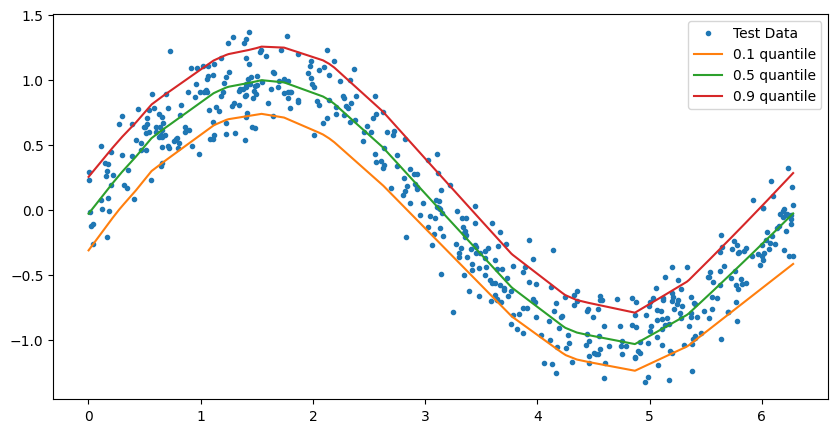

In [77]:
sort_indices=np.argsort(X_test[:,0])
X_test_sort=X_test[sort_indices]
y_test_sort=y_test[sort_indices]
preds = model.predict(X_test_sort)

plt.plot(X_test_sort,y_test_sort,'.')
plt.plot(X_test_sort,preds)

legend=["Test Data"]
quantiles_str=[str(quant)+" quantile" for quant in quantiles]
legend.extend(quantiles_str)
plt.legend(legend)
plt.show()

In [78]:
QuantileNetwork.quant_rate(y_test_sort,preds)

array([0.09 , 0.492, 0.896])